In [1]:
import pandas as pd
import datetime as dt
import pytz # timezone conversion, needed for GMT <> BST function
import matplotlib.pyplot as plt # for customising graphs

#replace this with the folder where the files are located on your PC
input_data_path = 'C:/Users/djb21211/OneDrive - University of Strathclyde/Documents/offhynetz/Scenarios/'

In [2]:
def sp_to_dt(SD, SP, period_start=True):
    """
    Converts a settlement date and settlement period to a timezone-aware
    datetime object
    Parameters
    ----------
    SD : datetime.date object
        the settlement date
    SP : int
        the settlement period (in range 1 to 50)
    period_start : bool
        whether the desired datetime object should relate to the start (True)
        or end (False) of the settlement period
    Returns
    -------
    datetime : datetime.datetime
        a timezone-aware datetime object
    """
    #check date object passed - not datetime
    if not isinstance(SD, dt.date):
        raise ValueError('Expected Settlement Date parameter not of type datetime.date')

    #minimum SP value check
    if SP < 1:
        raise ValueError('SP value of %d less than minimum value of 1' % SP)

    #maximum SP value check, taking into account transition days
    transition_days = [dt.date(x.year, x.month, x.day)
                       for x in pytz.timezone('Europe/London')._utc_transition_times]
    if SD in [x for x in transition_days if x.month<6]: #clocks go forward
        if SP > 46:
            raise ValueError('SP value of %d exceeds maximum value of 46 \
                             for forward clock change date' % SP)
    elif SD in [x for x in transition_days if x.month>6]: #clocks go back
        if SP > 50:
            raise ValueError('SP value of %d exceeds maximum value of 50 \
                             for backward clock change date' % SP)
    elif SP > 48:
        raise ValueError('SP value of %d exceeds maximum value of 48 for \
                         non-clock change date' % SP)

    datetime = dt.datetime(SD.year, SD.month, SD.day, tzinfo=pytz.utc)
    datetime += dt.timedelta(minutes=(SP-1)*30)
    if not period_start:
        datetime += dt.timedelta(minutes=30)

    # DST shift should only be applied on days after transition day
    # (as does not impact calculation until SP resets to 1)
    if SD in [x for x in transition_days if x.month<6]:
        pass
    elif SD in [x for x in transition_days if x.month>6] and SP > 2:
        datetime -= dt.timedelta(hours=1)
    else:
        datetime -= datetime.astimezone(pytz.timezone('Europe/London')).dst()
    return datetime

In [3]:
# example of how to use the above function: looks at year,month,date, time period on that date and converts it into time, eg 6.30am
sp_to_dt(dt.date(2021,1,1), 14)

datetime.datetime(2021, 1, 1, 6, 30, tzinfo=<UTC>)

In [4]:
# read in metered data from csv file to a dataframe
# create new timestamp column using above function applied to values in SD (Settlement Date) and SP (Settlement Period) columns
# set this new timestamp column as the index
# remove the now unwanted sd/sp columns
metered_df = pd.read_csv(input_data_path+'Historical data/2021/metered.csv', parse_dates=[0])
metered_df['timestamp'] = metered_df.apply(lambda row: sp_to_dt(row.sd, row.sp), axis=1)
metered_df.set_index('timestamp', inplace=True)
metered_df.drop(columns=['sd', 'sp'], inplace=True)
metered_df

C:\Users\djb21211\AppData\Local\Temp\ipykernel_8128\2032117579.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if SD in [x for x in transition_days if x.month<6]: #clocks go forward
C:\Users\djb21211\AppData\Local\Temp\ipykernel_8128\2032117579.py:34: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  elif SD in [x for x in transition_days if x.month>6]: #clocks go back
C:\Users\djb21211\AppData\Local\Temp\ipykernel_8128\2032117579.py:49: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be

,E_ABRTW-1,E_AIRSW-1,E_ASHWW-1,E_ASLVW-1,E_ASLVW-1_D,E_BABAW-1,E_BETHW-1,E_BNWKW-1,E_BRDUW-1,E_BRNLW-1,...,E_BLARW-1,T_AKGLW-3,T_MOWEO-1,T_MOWEO-2,T_MOWEO-3,T_TWSHW-1,T_WHLWB-1,T_KENNW-1,T_KTHRS-1,T_KTHRS-2
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,3.448,11.934,6.355,4.337,NaN,19.09,7.916,5.785,12.941,1.706,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:30:00+00:00,4.546,10.629,6.431,5.680,NaN,20.39,7.240,6.335,12.990,1.776,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:00:00+00:00,2.425,6.523,6.930,3.190,NaN,20.87,5.433,6.634,21.611,1.884,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:30:00+00:00,2.791,3.016,5.481,2.625,NaN,22.35,4.676,6.983,32.627,2.075,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 02:00:00+00:00,2.127,4.707,3.069,1.789,NaN,20.02,4.381,6.981,34.090,1.639,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 21:30:00+00:00,4.993,7.110,7.750,8.418,NaN,7.73,0.926,1.363,7.594,0.265,...,7.427,14.166,32.621,21.144,22.031,0.0,0.038,0.030,0.011,0.003
2021-12-31 22:00:00+00:00,8.882,5.327,9.173,10.751,NaN,8.86,0.702,1.443,4.444,0.156,...,9.447,21.007,31.806,22.967,24.726,0.0,0.038,0.025,0.011,0.003
2021-12-31 22:30:00+00:00,5.916,6.655,7.422,11.741,NaN,8.10,0.380,1.042,7.311,0.253,...,12.593,15.870,35.743,25.460,26.263,0.0,0.038,0.025,0.007,0.003


In [5]:
# repeat the above steps for the BAV data
bav_df = pd.read_csv(input_data_path+'Historical data/2021/BAVs.csv', parse_dates=[0])
bav_df['timestamp'] = bav_df.apply(lambda row: sp_to_dt(row.sd, row.sp), axis=1)
bav_df.set_index('timestamp', inplace=True)
bav_df.drop(columns=['sd', 'sp'], inplace=True)
bav_df

C:\Users\djb21211\AppData\Local\Temp\ipykernel_8128\2032117579.py:30: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  if SD in [x for x in transition_days if x.month<6]: #clocks go forward
C:\Users\djb21211\AppData\Local\Temp\ipykernel_8128\2032117579.py:34: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be considered non-comparable.Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  elif SD in [x for x in transition_days if x.month>6]: #clocks go back
C:\Users\djb21211\AppData\Local\Temp\ipykernel_8128\2032117579.py:49: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior.  In a future version these will be

,E_ABRTW-1,E_AIRSW-1,E_ASHWW-1,E_ASLVW-1,E_ASLVW-1_D,E_BABAW-1,E_BETHW-1,E_BNWKW-1,E_BRDUW-1,E_BRNLW-1,...,E_BLARW-1,T_AKGLW-3,T_MOWEO-1,T_MOWEO-2,T_MOWEO-3,T_TWSHW-1,T_WHLWB-1,T_KENNW-1,T_KTHRS-1,T_KTHRS-2
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 00:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 01:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-01-01 02:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 21:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31 22:00:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2021-12-31 22:30:00+00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


<AxesSubplot:xlabel='timestamp'>

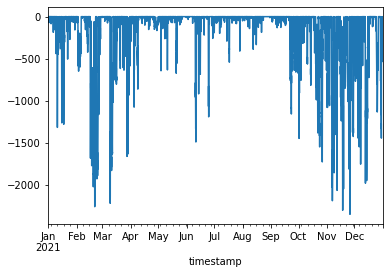

In [6]:
# create a timeseries plot of the BAV values summed across each row
bav_df.sum(axis=1).plot()

In [7]:
# make a new dataframe which is the sum of metered and BAV values
# need to multiply BAVs by -1 because they are recorded as negative energy
unconstrained_df = metered_df.fillna(0)+(-1*bav_df.fillna(0))
unconstrained_df

,E_ABRTW-1,E_AIRSW-1,E_ASHWW-1,E_ASLVW-1,E_ASLVW-1_D,E_BABAW-1,E_BETHW-1,E_BNWKW-1,E_BRDUW-1,E_BRNLW-1,...,E_BLARW-1,T_AKGLW-3,T_MOWEO-1,T_MOWEO-2,T_MOWEO-3,T_TWSHW-1,T_WHLWB-1,T_KENNW-1,T_KTHRS-1,T_KTHRS-2
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,3.448,11.934,6.355,4.337,0.0,19.09,7.916,5.785,12.941,1.706,...,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
2021-01-01 00:30:00+00:00,4.546,10.629,6.431,5.680,0.0,20.39,7.240,6.335,12.990,1.776,...,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
2021-01-01 01:00:00+00:00,2.425,6.523,6.930,3.190,0.0,20.87,5.433,6.634,21.611,1.884,...,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
2021-01-01 01:30:00+00:00,2.791,3.016,5.481,2.625,0.0,22.35,4.676,6.983,32.627,2.075,...,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
2021-01-01 02:00:00+00:00,2.127,4.707,3.069,1.789,0.0,20.02,4.381,6.981,34.090,1.639,...,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.000,0.000,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 21:30:00+00:00,4.993,7.110,7.750,8.418,0.0,7.73,0.926,1.363,7.594,0.265,...,7.427,14.166,32.621,21.144,22.031,0.0,0.038,0.030,0.011,0.003
2021-12-31 22:00:00+00:00,8.882,5.327,9.173,10.751,0.0,8.86,0.702,1.443,4.444,0.156,...,9.447,21.007,31.806,22.967,24.726,0.0,0.038,0.025,0.011,0.003
2021-12-31 22:30:00+00:00,5.916,6.655,7.422,11.741,0.0,8.10,0.380,1.042,7.311,0.253,...,12.593,15.870,35.743,25.460,26.263,0.0,0.038,0.025,0.007,0.003


In [8]:
# read in the BMU metadata so we can make use of the information about their generation types
# (in future could also use the GSP/Flop data to disaggregate by region)
bmu_metadata = pd.read_csv(input_data_path+'Background data/Scotland_BMUs.csv')
bmu_metadata

,Type,BMU,Name,GSP region,FLOP Zone
0,EfW,2__NSMAR001,Viridor Dunbar EFW,South Scotland,S6
1,Wind (Onshore),2__PENEC001,Rothes Windfarm,North Scotland,T1
2,Hydro,2__PMARB001,Lochaber Hydro,North Scotland,T1
3,Hydro,2__PMARB002,Kinlochleven Hydro,North Scotland,T1
4,Wind (Onshore),2__PPGEN001,Rothes (Cairn Uish) Wind Farm,North Scotland,T1
...,...,...,...,...,...
229,Demand,T_WHISTLD-1,HMNB Whistlefield,North Scotland,T4
230,Battery,T_WHLWB-1,Whitelee Wind Farm Battery,South Scotland,S6
231,Wind (Onshore),T_WISTW-2,Brockloch Rig 2 Windfarm,South Scotland,S6
232,Virtual parties,V__NFLEX001,South Scotland GSP Group - Flexitricity Limited,South Scotland,S6


In [9]:
# use the metadata to get the BMU IDs of all onshore or offshore wind generators
wind_bmus = bmu_metadata[(bmu_metadata.Type == 'Wind (Onshore)') | (bmu_metadata.Type == 'Wind (Offshore)')].BMU.values
wind_bmus

array(['2__PENEC001', '2__PPGEN001', '2__PPGEN002', '2__PPGEN003',
       '2__PSTAT001', '2__PSTAT002', 'E_ABRTW-1', 'E_AIRSW-1',
       'E_ASHWW-1', 'E_ASLVW-1', 'E_BABAW-1', 'E_BETHW-1', 'E_BLARW-1',
       'E_BNWKW-1', 'E_BRDUW-1', 'E_BRNLW-1', 'E_BRYBW-1', 'E_BTUIW-2',
       'E_BTUIW-3', 'E_CLDRW-1', 'E_CLFLW-1', 'E_CNCLW-1', 'E_CRGTW-1',
       'E_DALSW-1', 'E_GDSTW-1', 'E_GLCHW-1', 'E_GLOFW-1', 'E_HBHDW-1',
       'E_HLGLW-1', 'E_HLTWW-1', 'E_HRHLW-1', 'E_HYWDW-1', 'E_KINCW-1',
       'E_MINSW-1', 'E_MOYE-1', 'E_MOYEW-1', 'E_SWBKW-1', 'E_TLYMW-1',
       'E_TULWW-1', 'E_TULWW-2', 'T_ABRBO-1', 'T_ACHRW-1', 'T_AFTOW-1',
       'T_AKGLW-2', 'T_AKGLW-3', 'T_ANSUW-1', 'T_ARCHW-1', 'T_BDCHW-1',
       'T_BEATO-1', 'T_BEATO-2', 'T_BEATO-3', 'T_BEATO-4', 'T_BEINW-1',
       'T_BHLAW-1', 'T_BLKWW-1', 'T_BLLA-1', 'T_BLLA-2', 'T_CGTHW-1',
       'T_CLDCW-1', 'T_CLDNW-1', 'T_CLDSW-1', 'T_COUWW-1', 'T_CRDEW-1',
       'T_CRDEW-2', 'T_CRGHW-1', 'T_CRMLW-1', 'T_CRYRW-2', 'T_CRYRW-3',
       'T

In [10]:
# we can then filter the timeseries data by these values
# to return a dataframe which only has wind BMUs
wind_ts_df = unconstrained_df.filter(wind_bmus)
wind_ts_df

,E_ABRTW-1,E_AIRSW-1,E_ASHWW-1,E_ASLVW-1,E_BABAW-1,E_BETHW-1,E_BLARW-1,E_BNWKW-1,E_BRDUW-1,E_BRNLW-1,...,T_STLGW-3,T_STRNW-1,T_TDBNW-1,T_TRLGW-1,T_TWSHW-1,T_WDRGW-1,T_WHIHW-1,T_WHILW-1,T_WHILW-2,T_WISTW-2
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,3.448,11.934,6.355,4.337,19.09,7.916,0.000,5.785,12.941,1.706,...,10.267,19.786,2.497,2.513,0.0,0.000,10.478,39.025,17.372,9.193
2021-01-01 00:30:00+00:00,4.546,10.629,6.431,5.680,20.39,7.240,0.000,6.335,12.990,1.776,...,11.928,19.587,2.179,2.541,0.0,0.000,7.766,38.575,9.686,6.866
2021-01-01 01:00:00+00:00,2.425,6.523,6.930,3.190,20.87,5.433,0.000,6.634,21.611,1.884,...,10.025,19.573,2.192,1.268,0.0,0.000,7.823,28.145,5.408,5.473
2021-01-01 01:30:00+00:00,2.791,3.016,5.481,2.625,22.35,4.676,0.000,6.983,32.627,2.075,...,8.158,22.429,1.992,0.970,0.0,0.000,6.585,18.850,7.062,4.317
2021-01-01 02:00:00+00:00,2.127,4.707,3.069,1.789,20.02,4.381,0.000,6.981,34.090,1.639,...,7.751,22.957,2.671,0.717,0.0,0.000,5.785,13.325,6.515,4.656
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 21:30:00+00:00,4.993,7.110,7.750,8.418,7.73,0.926,7.427,1.363,7.594,0.265,...,7.269,6.877,3.360,4.770,0.0,11.669,7.920,30.773,26.125,21.115
2021-12-31 22:00:00+00:00,8.882,5.327,9.173,10.751,8.86,0.702,9.447,1.443,4.444,0.156,...,13.977,7.155,4.728,6.837,0.0,10.176,9.727,53.753,40.082,21.911
2021-12-31 22:30:00+00:00,5.916,6.655,7.422,11.741,8.10,0.380,12.593,1.042,7.311,0.253,...,17.558,6.364,2.314,7.627,0.0,13.954,9.563,48.013,34.118,23.151


<AxesSubplot:xlabel='timestamp'>

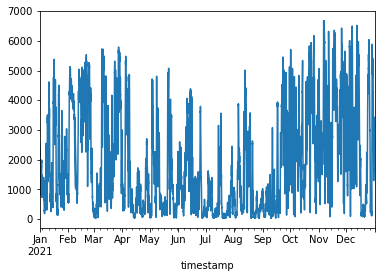

In [11]:
# plot the total wind output by time
(wind_ts_df*2).sum(axis=1).plot()

In [12]:
# instead, maybe rather than just looking at wind 
# we can group all outputs by their generator type
# first, create a dictionary from the metadata which maps BMU IDs to Types
type_mapping = dict(zip(bmu_metadata['BMU'], bmu_metadata['Type']))
type_mapping

{'2__NSMAR001': 'EfW',
 '2__PENEC001': 'Wind (Onshore)',
 '2__PMARB001': 'Hydro',
 '2__PMARB002': 'Hydro',
 '2__PPGEN001': 'Wind (Onshore)',
 '2__PPGEN002': 'Wind (Onshore)',
 '2__PPGEN003': 'Wind (Onshore)',
 '2__PSTAT001': 'Wind (Onshore)',
 '2__PSTAT002': 'Wind (Onshore)',
 'E_ABRTW-1': 'Wind (Onshore)',
 'E_AIRSW-1': 'Wind (Onshore)',
 'E_ASHWW-1': 'Wind (Onshore)',
 'E_ASLVW-1': 'Wind (Onshore)',
 'E_ASLVW-1_D': 'Demand',
 'E_BABAW-1': 'Wind (Onshore)',
 'E_BETHW-1': 'Wind (Onshore)',
 'E_BLARW-1': 'Wind (Onshore)',
 'E_BNWKW-1': 'Wind (Onshore)',
 'E_BRDUW-1': 'Wind (Onshore)',
 'E_BRNLW-1': 'Wind (Onshore)',
 'E_BROXES-1': 'Battery',
 'E_BRYBW-1': 'Wind (Onshore)',
 'E_BTUIW-2': 'Wind (Onshore)',
 'E_BTUIW-3': 'Wind (Onshore)',
 'E_CLAC-1': 'Hydro',
 'E_CLDRW-1': 'Wind (Onshore)',
 'E_CLFLW-1': 'Wind (Onshore)',
 'E_CNCLW-1': 'Wind (Onshore)',
 'E_CRGTW-1': 'Wind (Onshore)',
 'E_DALSW-1': 'Wind (Onshore)',
 'E_FASN-2': 'Hydro',
 'E_FASN-3': 'Hydro',
 'E_FASN-4': 'Hydro',
 'E_GDS

In [13]:
# then group the values in the dataframe by this mapping, telling it to aggregate by summing values
# (could also do mean, minimum, maximum, etc)
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.groupby.html
unconstrained_df.groupby(type_mapping, axis=1).sum()

,Battery,CCGT,CHP,Coal,Demand,Hydro,Nuclear,PS,Peaker,Stabiliser,Transformer,Wind (Offshore),Wind (Onshore)
timestamp,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,0.124,589.916,86.655,0.0,119.632,107.6000,1075.930,1.44,0.0,0.000,4.526,319.672,943.4150
2021-01-01 00:30:00+00:00,0.020,590.170,86.685,0.0,118.862,105.6960,1075.238,1.42,0.0,0.000,4.528,333.636,925.3910
2021-01-01 01:00:00+00:00,0.950,590.044,86.625,0.0,118.800,90.8740,1073.328,1.46,0.0,0.000,4.520,338.883,872.5540
2021-01-01 01:30:00+00:00,0.042,590.270,86.635,0.0,119.043,83.2050,1073.622,1.44,0.0,0.000,4.521,338.524,816.4030
2021-01-01 02:00:00+00:00,0.011,590.078,86.715,0.0,119.955,83.1740,1073.974,1.42,0.0,0.000,4.527,345.866,791.1040
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 21:30:00+00:00,0.200,0.000,73.552,0.0,103.666,197.8090,892.188,51.57,0.0,0.014,0.730,132.277,970.6720
2021-12-31 22:00:00+00:00,0.879,0.000,73.642,0.0,98.400,149.4060,892.856,9.40,0.0,0.014,0.696,139.933,1108.1390
2021-12-31 22:30:00+00:00,0.380,0.000,73.582,0.0,97.152,119.6902,892.900,3.66,0.0,0.010,0.690,157.318,1168.6380


[]

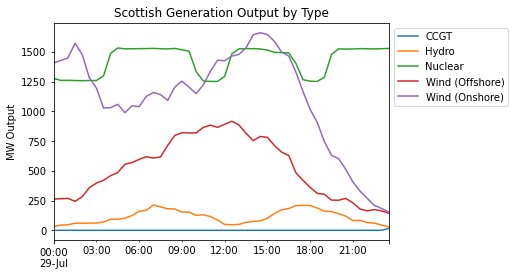

In [14]:
# let's plot MW output of different Scottish generation types for a couple of days in August
# need to drop Demand column
# customisation is by using matplotlib library
# https://matplotlib.org/
# note that data is in MWh per 30 mins (energy), so to get MW (power) we should multiply by 2
ax = (unconstrained_df*2).groupby(type_mapping, axis=1).sum().drop(columns=['Demand','Peaker','Stabiliser','Transformer','Battery','CHP','PS','Coal'])['2021-07-29':'2021-07-29'].plot()
ax.set_title("Scottish Generation Output by Type",color='black')
ax.legend(bbox_to_anchor=(1.0, 1.0))
ax.set_ylabel("MW Output")
ax.set_xlabel("")
ax.plot()

In [15]:
# convert absolute values to capacity factors
# by dividing each entry by the maximum entry for that generator over the whole year
# (this does make various assumptions - so good to also check for weird values)
unconstrained_cf_df = (metered_df.fillna(0)+(-1*bav_df.fillna(0)))/(metered_df.fillna(0).max())
unconstrained_cf_df

,E_ABRTW-1,E_AIRSW-1,E_ASHWW-1,E_ASLVW-1,E_ASLVW-1_D,E_BABAW-1,E_BETHW-1,E_BNWKW-1,E_BRDUW-1,E_BRNLW-1,...,E_BLARW-1,T_AKGLW-3,T_MOWEO-1,T_MOWEO-2,T_MOWEO-3,T_TWSHW-1,T_WHLWB-1,T_KENNW-1,T_KTHRS-1,T_KTHRS-2
timestamp,,,,,,,,,,,,,,,,,,,,,
2021-01-01 00:00:00+00:00,0.193263,0.683231,0.367192,0.346350,NaN,0.733666,0.550602,0.811360,0.365060,0.478676,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2021-01-01 00:30:00+00:00,0.254806,0.608519,0.371584,0.453602,NaN,0.783628,0.503582,0.888499,0.366442,0.498316,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2021-01-01 01:00:00+00:00,0.135923,0.373447,0.400416,0.254752,NaN,0.802075,0.377895,0.930435,0.609636,0.528620,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2021-01-01 01:30:00+00:00,0.156437,0.172668,0.316693,0.209631,NaN,0.858955,0.325242,0.979383,0.920393,0.582211,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
2021-01-01 02:00:00+00:00,0.119220,0.269480,0.177327,0.142869,NaN,0.769408,0.304723,0.979102,0.961663,0.459877,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2021-12-31 21:30:00+00:00,0.279861,0.407053,0.447796,0.672257,NaN,0.297079,0.064408,0.191164,0.214223,0.074355,...,0.448680,0.356180,0.218653,0.141768,0.151945,0.0,0.047799,0.857143,0.008041,0.004329
2021-12-31 22:00:00+00:00,0.497842,0.304975,0.530017,0.858569,NaN,0.340507,0.048828,0.202384,0.125363,0.043771,...,0.570712,0.528186,0.213190,0.153991,0.170532,0.0,0.047799,0.714286,0.008041,0.004329
2021-12-31 22:30:00+00:00,0.331596,0.381004,0.428844,0.937630,NaN,0.311299,0.026431,0.146143,0.206240,0.070988,...,0.760768,0.399024,0.239579,0.170706,0.181133,0.0,0.047799,0.714286,0.005117,0.004329


In [16]:
# filter for wind BMUs, find the average CF across all BMUs
# and save to a csv file with calliope column names
wind_ts_df = unconstrained_cf_df.filter(wind_bmus).mean(axis=1)
wind_ts_df.to_csv('scottish_wind.csv', header=['region1'], index_label='', date_format='%Y-%m-%d %H:%M')

<AxesSubplot:xlabel='timestamp'>

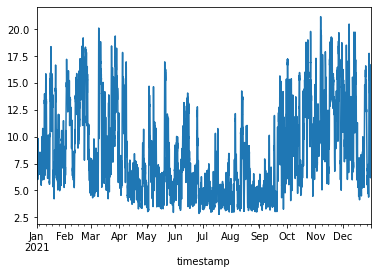

In [17]:
(unconstrained_cf_df.mean(axis=1)*30).plot() #2021 data upscaled to 2035 30GW of wind

<AxesSubplot:>

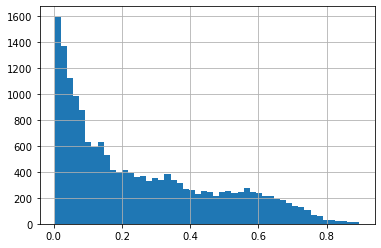

In [18]:
# plot histogram to show distribution of wind CFs
wind_ts_df.hist(bins=50)